<a href="https://colab.research.google.com/github/swarthyPig/Raspberry-Pi_DHT22_Weather_Station_with_AI/blob/master/machine%20learning/new_Keras_levelUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


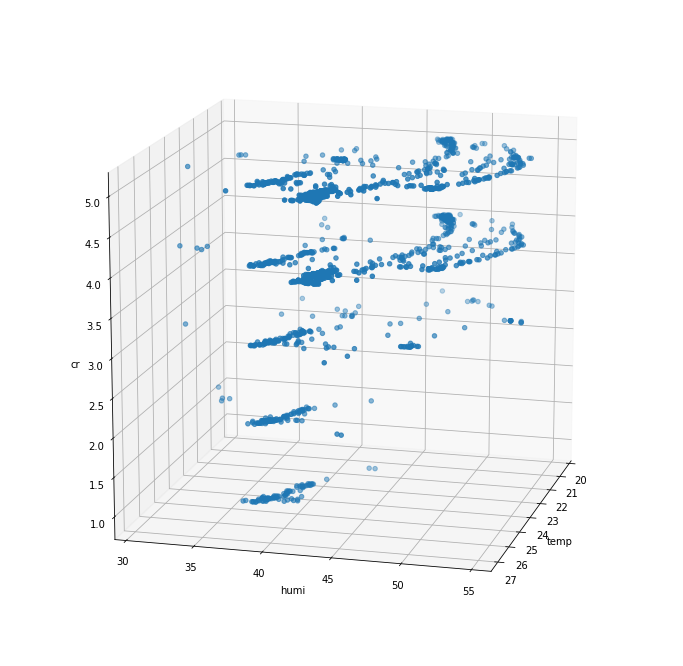

In [1]:
from __future__ import print_function
import pandas as pd
import seaborn as sns

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

data = read_csv('iot_data.csv', sep=',')

data_np = np.array(data, dtype=np.float32)

xs = np.array(data_np[:,0], dtype=np.float32)
ys = np.array(data_np[:,1], dtype=np.float32)
zs = np.array(data_np[:,2], dtype=np.float32)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('temp')
ax.set_ylabel('humi')
ax.set_zlabel('cr')
ax.view_init(15, 15)

plt.show()

### Load data
- data : pandas dataframe
- data_np : numpy array

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 3 columns):
temperature    1628 non-null float64
humidity       1628 non-null float64
cr             1628 non-null float64
dtypes: float64(3)
memory usage: 38.2 KB


In [3]:
data.describe()

,temperature,humidity,cr
count,1628.000000,1628.000000,1628.000000
mean,24.530780,43.952420,4.049754
std,1.868578,4.608971,1.133111
min,20.300000,30.900000,1.000000
25%,23.100000,40.237500,4.000000
50%,25.200000,42.950000,4.000000
75%,25.950000,47.500000,5.000000
max,27.100000,54.650000,5.000000


In [4]:
pd.DataFrame(data).describe()

,temperature,humidity,cr
count,1628.000000,1628.000000,1628.000000
mean,24.530780,43.952420,4.049754
std,1.868578,4.608971,1.133111
min,20.300000,30.900000,1.000000
25%,23.100000,40.237500,4.000000
50%,25.200000,42.950000,4.000000
75%,25.950000,47.500000,5.000000
max,27.100000,54.650000,5.000000


### Split data to the numeric data (x_data) and label (y_data; uint8)

In [5]:
# Split data to the numeric data (x_data) and label (y_data; uint8)

x_data = data_np[:, 0:-1] # temp, humi
y_data = data_np[:, [-1]] # cr

x_data.shape,y_data.shape

((1628, 2), (1628, 1))

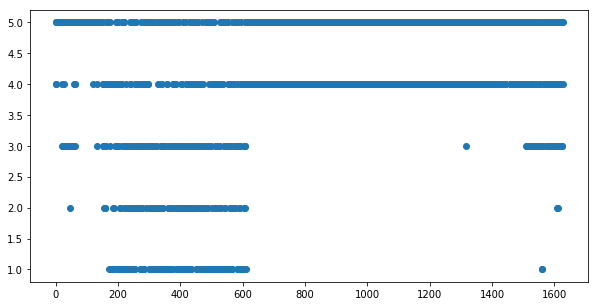

In [6]:
plt.figure(figsize=(10,5))
plt.plot(y_data,'o')

(0, 6)

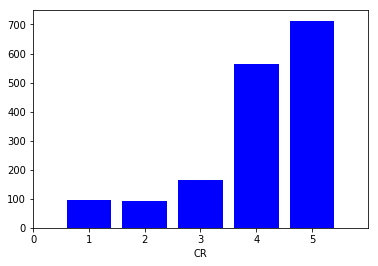

In [7]:
colors = ['blue']
# ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
bins = np.arange(7) - 0.5
plt.hist(y_data, bins, histtype='bar',color=colors, rwidth=0.8)
plt.xlabel('CR')
plt.xticks(range(6))
plt.xlim([0, 6])


Text(0.5, 1.05, 'Scatterplot of data')

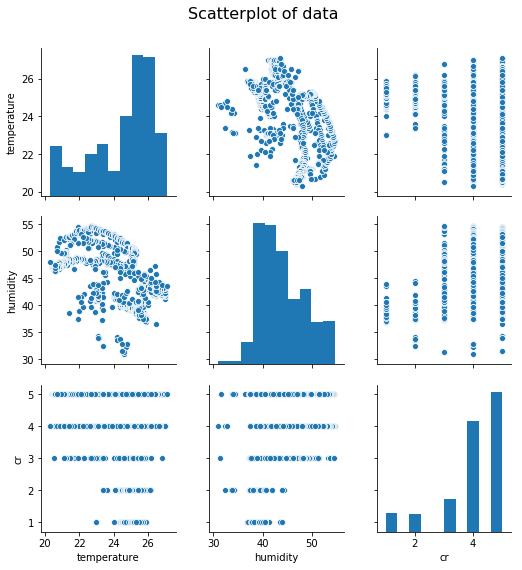

In [8]:
sns.pairplot(data.iloc[:,0:])
plt.suptitle('Scatterplot of data', y=1.05, fontsize = 16)

### Rescaling data using all numeric data but cr label

In [0]:
# Scaling only x_data -> X
# Min-max Scaling(normalization) : 값들이 이동되어, 결국 0에서 1사이의 범위에서 재스케일링됨
# 데이터에서 최소값을 뺀 후 최대값과 최소값의 차이로 나누는 것.
from sklearn.preprocessing import MinMaxScaler
sc= MinMaxScaler().fit(x_data)
X= sc.transform(x_data)
# y= y.reshape(-1,1)
# y=sc.fit_transform(y_data)

In [11]:
X.shape, x_data.shape, y_data.shape

((1628, 2), (1628, 2), (1628, 1))

Text(0.5, 1.05, 'Scatterplot of rescaled data')

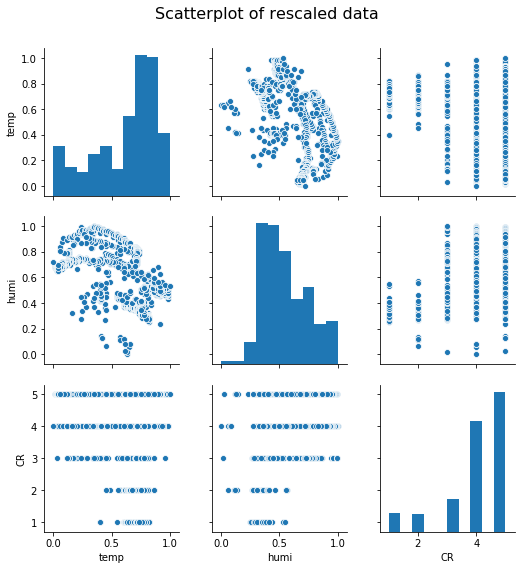

In [10]:
# Scatterplot of rescaled data
cols = ['temp', 'humi', 'CR']
sns.pairplot(pd.DataFrame(np.c_[X,zs.reshape(-1,1)], columns=cols))
plt.suptitle('Scatterplot of rescaled data', y=1.05, fontsize = 16)

In [12]:
# all data : (scaled x_data, zs) : (X, y_data)
x_train, x_test, y_train, y_test = train_test_split(X, y_data,    # zs.reshape(-1,1)
                                                    test_size=0.2, random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# data up to 600
# x_train, x_test, y_train, y_test = train_test_split(X[:600], zs[:600], 
#                                                     test_size=0.2, random_state=0)


(1302, 2)
(1302, 1)
(326, 2)
(326, 1)


### One-hot encoding for classification in Keras

- CR 값이 1~5 (keras로 cr 값을 정수로 예측)
- Logistic regression과 유사한 확률을 이용한 예측

In [13]:
# One-hot encoding of y_train and y_test labels (only execute once!)
# One-hot encoding : 여러개의 Y값을 0과 1로만 이루어진 형태로 바꾸어주는 기법

num_classes=5
# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train-1, num_classes)  #  .reshape((-1,))
y_test = np_utils.to_categorical(y_test-1, num_classes)
print('New y_train shape: ', y_train.shape)
print('New y_test shape: ', y_test.shape)
# 

New y_train shape:  (1302, 5)
New y_test shape:  (326, 5)


In [14]:
# result of one-hot encoding (5-fold levels)
y_train[:5],y_test[:5]

(array([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]], dtype=float32))

***

### Keras model for classifiying CR of five lebels;1,2,3,4,5.

In [15]:
# Check data structure
x_data.shape, x_train.shape, y_train.shape, x_test.shape, y_test.shape  # y_train, y_test : one-hot encoded

((1628, 2), (1302, 2), (1302, 5), (326, 2), (326, 5))

### Keras model with two deep layer

In [16]:
# create simple model with light model capacity 
model_s = Sequential()  # simple model

#get number of columns in training data
n_cols = x_train.shape[1]
print(n_cols)
#add layers to model
# ELU = ReLu 의 특성 및 장점을 공유, 그래디언트가 죽지 않는 장점
model_s.add(Dense(100, kernel_initializer='normal', 
                  activation='elu', input_shape=(n_cols,)))
model_s.add(Dense(10, kernel_initializer='normal', 
                  activation='elu'))
# model_s.add(Dense(10, kernel_initializer='normal', 
#                   activation='elu'))
model_s.add(Dropout(0.5)) # 일부 뉴런을 꺼서 학습하는 방식, 일종의 앙상블(ensemble) 효과
                          # 학습시 : 뉴런을 무작위로 끊음, 테스트시 : 모든 뉴런을 사용
# softmax = 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이되는 특성을 가짐
model_s.add(Dense(y_test.shape[1], kernel_initializer='normal', 
                  activation='softmax'))


2
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model_s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
Total params: 1,365
Trainable params: 1,365
Non-trainable params: 0
_________________________________________________________________


In [0]:
# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for 3, 5 or 10 consecutive epochs,
# training stops early
# and save the best model
# early stopping : 학습을 일찍 중단하는 방식, overfitting 방지
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model_s.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # monitor='acc', patience=3
]
# set early stopping monitor so the model stops training when it won't improve anymore
# early_stopping_monitor = EarlyStopping(patience=5)

In [0]:
# compile model using mse as a measure of model performance
# model_s.compile(optimizer='adam', loss='mean_squared_error')
# rmsprop = RMSprop(lr=0.01)
# Adam = RMSProp + Momentum
# Nadam = Adam + NAG
# categorical_crossentropy : 범주형 교차 엔트로피(일반적인 분류)
model_s.compile(loss='categorical_crossentropy', optimizer='Nadam',  # 'Adam', mean_squared_error
              metrics=['accuracy'])   # loss='sparse_categorical_crossentropy', 'mean_squared_error'


In [20]:
# hist_s = model_s.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=100, 
#                    batch_size=50, callbacks=callbacks_list)
hist_s = model_s.fit(x_train, y_train, validation_split=0.25, batch_size=20, #20, # 32, #24, 48
                 epochs = 200, verbose=1, callbacks=callbacks_list)
print('\nAccuracy: {:.4f}'.format(model_s.evaluate(x_test, y_test)[1]))

Instructions for updating:
Use tf.cast instead.
Train on 976 samples, validate on 326 samples
Epoch 1/200
976/976 [==============================] - 0s 321us/step - loss: 1.4227 - acc: 0.4221 - val_loss: 1.2265 - val_acc: 0.4479
Epoch 2/200
976/976 [==============================] - 0s 72us/step - loss: 1.3161 - acc: 0.4119 - val_loss: 1.2241 - val_acc: 0.4479
Epoch 3/200
976/976 [==============================] - 0s 73us/step - loss: 1.2723 - acc: 0.4078 - val_loss: 1.1960 - val_acc: 0.4479
Epoch 4/200
976/976 [==============================] - 0s 81us/step - loss: 1.2527 - acc: 0.4006 - val_loss: 1.1825 - val_acc: 0.4509
Epoch 5/200
976/976 [==============================] - 0s 75us/step - loss: 1.2491 - acc: 0.4180 - val_loss: 1.1830 - val_acc: 0.4448
Epoch 6/200
976/976 [==============================] - 0s 78us/step - loss: 1.2155 - acc: 0.4160 - val_loss: 1.1760 - val_acc: 0.4448
Epoch 7/200
976/976 [==============================] - 0s 75us/step - loss: 1.2203 - acc: 0.4098 - va

In [21]:
# get predictions
y_pred = model_s.predict(x_test)
np.argmax(y_pred[:100],axis=1)+1

array([5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 1, 5, 1, 5, 5, 1, 5, 5, 1, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5,
       5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 1, 5, 5, 1, 5, 5, 1, 5, 5,
       1, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 1,
       5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 1, 5])

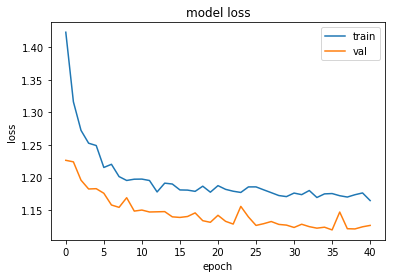

In [22]:
# summarize history for loss
plt.plot(hist_s.history['loss'])
plt.plot(hist_s.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [23]:
np.mean(hist_s.history['acc'])  # 

0.4167582977012765

In [24]:
np.max(hist_s.history['acc'])  # 

0.4313524599935188

In [25]:
X[:3]

array([[0.16176462, 0.896842  ],
       [0.3308823 , 0.8294735 ],
       [0.32352948, 0.825263  ]], dtype=float32)

In [26]:
# model에 임의의 값을 넣어 test
#model.predict(x_train)
# sc= MinMaxScaler()
tst1 = sc.transform(np.array([22.2,45.4]).reshape(1, -1))
tst1

array([[0.27941173, 0.61052629]])

> 예측 확률이 제일 큰 cr 결정: cr -> 5

In [27]:
# get predictions
y_pred = model_s.predict(x_test)
np.argmax(y_pred[:10],axis=1)+1

array([5, 5, 5, 1, 5, 5, 5, 5, 5, 5])

In [28]:
# 모델평가
test_loss, test_acc = model_s.evaluate(x_test, y_test)
print('정확도 :', test_acc)

326/326 [==============================] - 0s 38us/step
정확도 : 0.45398773042702234


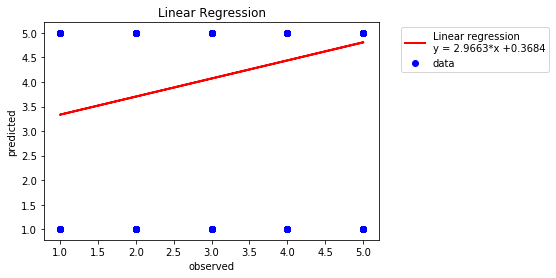

In [29]:
# print the linear regression and display datapoints
from sklearn.linear_model import LinearRegression  
regressor = LinearRegression()  
# true_y=y_test #[:,np.newaxis] 
true_y = np.argmax(y_test,axis=1)+1# np.argmax(y_test, axis=1)  # decode one-hot encoding
pred_y = np.argmax(y_pred,axis=1)+1
regressor.fit(true_y.reshape(-1, 1), pred_y.reshape(-1, 1))  
y_fit = regressor.predict(pred_y.reshape(-1, 1)) 

reg_intercept = round(regressor.intercept_[0],4)
reg_coef = round(regressor.coef_.flatten()[0],4)
reg_label = "y = " + str(reg_intercept) + "*x +" + str(reg_coef)

plt.scatter(true_y.reshape(-1, 1), pred_y.reshape(-1, 1), color='blue', label= 'data')
plt.plot(pred_y.reshape(-1, 1), y_fit, color='red', linewidth=2, label = 'Linear regression\n'+reg_label) 
plt.title('Linear Regression')
plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [30]:
# get weight, bias value
print(model_s.get_weights())

[array([[-0.01363138, -0.03386339, -0.08779784, -0.08488846,  0.02196778,
         0.0414383 ,  0.08273396,  0.03579571,  0.01557431,  0.02161262,
         0.03969014, -0.03010929,  0.00046346, -0.01993665, -0.05616187,
        -0.0535584 , -0.04088245,  0.00886916, -0.00286763,  0.06055662,
         0.05351143, -0.04552429, -0.02060068, -0.00046065,  0.11594342,
        -0.04956986,  0.05295533, -0.040918  , -0.04072607, -0.03049105,
         0.04473785,  0.10946779, -0.024893  ,  0.1063983 , -0.00341951,
        -0.01430188, -0.0734541 , -0.10715262, -0.01166057, -0.03818372,
         0.08030669, -0.00861795, -0.03387897, -0.01520555,  0.02400674,
         0.02055859, -0.03093257, -0.06256726,  0.03136537,  0.12910564,
         0.04759194,  0.01240948, -0.03019389,  0.01107652, -0.03150935,
         0.00054009,  0.07716881,  0.0998846 , -0.00374807,  0.00514827,
         0.07925826, -0.05348315, -0.0131397 ,  0.09292866, -0.00448785,
         0.04009048,  0.04043345,  0.02401346,  0.

***